# Run Sandwich Attacks on Swaps from the Public Mempool

In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import os
import sys
import math

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")

import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from datetime import datetime, timezone


# Set display options
pd.set_option("display.max_colwidth", None)  # Display entire cell content
pd.set_option("display.max_rows", 50)  # Display all rows
pd.set_option("display.max_columns", None)  # Display all columns


from dotenv import load_dotenv
from pool_state import v3Pool
from sqlalchemy import create_engine
from tqdm import tqdm

from moralis import evm_api


load_dotenv(override=True)
# from experiments.random_permutations import load_pool

from experiments.preload_pool_cache import load_pool_from_blob
from experiments.calculate_simple_sandwich import (
    get_data,
    SwapData,
    single_sandwich_mev,
    max_frontrun,
    auto_sandwich_mev,
    SimpleSandwich,
)


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri_mp = os.environ["POSTGRESQL_URI_MP"]
postgres_uri_us = os.environ["POSTGRESQL_URI_US"]
azure_storage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]
moralis_api_key = os.environ["MORALIS_API_KEY"]

## Get the Data

### Populate the swap data we have with the block number that the swap appeared in

In [3]:
df = get_data()

df.head()

amountIn  \
pool                                       block_number                
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0     3200000000   
                                           17552242.0      303798589   
                                           17552250.0    16102020684   
                                           17552252.0     6543850000   
                                           17552278.0      150000000   

                                                                amountOutMin  \
pool                                       block_number                        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    1608133671221393483   
                                           17552242.0     160355281886090203   
                                           17552250.0    8532306101844837653   
                                           17552252.0    3467552154643320542   
                                           17552278.0      79798648054443290   

                                                                                             token0  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552242.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552250.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552252.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   
                                           17552278.0    0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48   

                                                         fee  \
pool                                       block_number        
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    500   
                                           17552242.0    500   
                                           17552250.0    500   
                                           17552252.0    500   
                                           17552278.0    500   

                                                                                             token1  \
pool                                       block_number                                               
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552242.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552250.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552252.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   
                                           17552278.0    0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2   

                                                                                                                       hash  \
pool                                       block_number                                                                       
0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 17552211.0    0xcccbb87fc3e5e2b7851adc2140f46603c39eebef648048d59904987f47a9aa50   
                                           17552242.0    0x4c1da0dcc8367691658daa4bf50af22df275e8898975edfb96c65625da07098d   
                                           17552250.0    0x94f9a95e35ef12f68ce0b4aa1a40a15e8f72472f5af549fc90dc884909db6522   
                                           17552252.0    0xc708f2903a47f281da6eaa12ea3e35f5c396a2567e3f7478058c1102a11f2bd4   
                                           17552278.0    0x3aebe0e7c4c49d9e98f394e4c5141b731ebf63c73a74b388bcb5258c61440fe3   

                                                                              first_seen  
pool                                       block_number                                   
0x88e6a0c2ddd26feeb64f039a2c4

## Get a pool and do some initial testing

In [4]:
swap_data = df[df.hash == '0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2']

swap = SwapData(**swap_data.reset_index().to_dict('records')[0]) # type: ignore

swap

SwapData(pool='0x78d4e81fc84a1ce367e90936e49a74a9052137e8', block_number=17578916.0, amountIn='10000000000000000000', amountOutMin='466622823911182083', token0='0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', fee='10000', token1='0x2890df158d76e584877a1d17a85fea3aeeb85aa6', hash='0x503ff2a5421b7a3e9594051eb933ad5ea01a9ccc0d76a41b5fc2df945af2a7f2', first_seen=Timestamp('2023-06-28 16:09:49.897000+0000', tz='UTC'))

In [5]:
pool = load_pool_from_blob(
    str(swap_data.index.get_level_values(0)[0]),
    postgres_uri_us,
    azure_storage_uri,
    "uniswap-v3-pool-cache",
    verbose=True,
    invalidate_before_date=datetime(2023, 8, 16, tzinfo=timezone.utc),
)

Loading pool from Azure blob storage cache


In [6]:
assert pool

max_frontrun(
    pool,
    swap,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 2000000.0
2: Trying 4000000.0
3: Trying 8000000.0
4: Trying 16000000.0
5: Trying 32000000.0
6: Trying 64000000.0
7: Trying 128000000.0
8: Trying 256000000.0
9: Trying 512000000.0
10: Trying 1024000000.0
11: Trying 2048000000.0
12: Trying 4096000000.0
13: Trying 8192000000.0
14: Trying 16384000000.0
15: Trying 32768000000.0
16: Trying 65536000000.0
17: Trying 131072000000.0
18: Trying 262144000000.0
19: Trying 524288000000.0
20: Trying 1048576000000.0
21: Trying 2097152000000.0
22: Trying 4194304000000.0
23: Trying 8388608000000.0
24: Trying 16777216000000.0
25: Trying 33554432000000.0
26: Trying 67108864000000.0
27: Trying 134217728000000.0
28: Trying 268435456000000.0
29: Trying 536870912000000.0
30: Trying 1073741824000000.0
31: Trying 2147483648000000.0
32: Trying 4294967296000000.0
33: Trying 8589934592000000.0
34: Trying 1.7179869184e+16
35: Trying 3.4359738368e+16
36: Trying 6.8719476736e+16
37: Trying 1.37438953472e+17
38: Trying 2.74877906944e+17
0

2.72994664448e+17

In [8]:
assert pool is not None

profit, gas, prices = single_sandwich_mev(
    pool,
    swap,
    int(2.72994664448e+17),
    pool_fee=True,
)

print(f"Profit: {profit / 1e18}")
print(f"Gas: {gas}")
print(f"Prices: {prices}")

Profit: 0.003185129981081248
Gas: 0.006719305386569982
Prices: (4.56768883595478, 4.569668914667892, 4.642682234572798, 4.64065881939532)


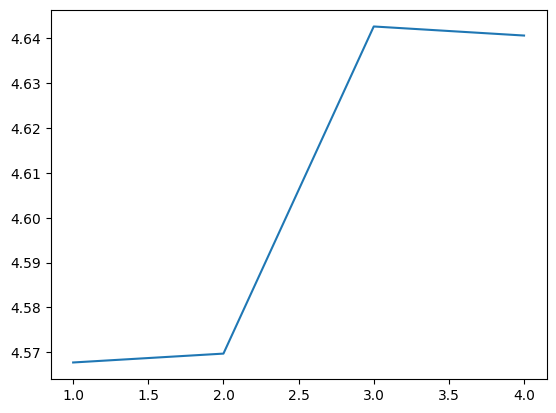

In [9]:
plt.plot([1,2,3,4], prices);

In [16]:
# See if the profit of the profitable attack is maximized by inserting the maximum size frontrunning swap

xs = []
ys = []

inp = 1e12

while inp <= int(2.72994664448e+19):
    print(f"Running {inp:.2e} <= 2.73e+19")
    profit, gas, prices = single_sandwich_mev(
        pool,
        swap,
        int(inp),
        pool_fee=True,
    )

    xs.append(inp)
    ys.append(profit)

    inp *= 2

Running 1.00e+12 <= 2.73e+19
Running 2.00e+12 <= 2.73e+19
Running 4.00e+12 <= 2.73e+19
Running 8.00e+12 <= 2.73e+19
Running 1.60e+13 <= 2.73e+19
Running 3.20e+13 <= 2.73e+19
Running 6.40e+13 <= 2.73e+19
Running 1.28e+14 <= 2.73e+19
Running 2.56e+14 <= 2.73e+19
Running 5.12e+14 <= 2.73e+19
Running 1.02e+15 <= 2.73e+19
Running 2.05e+15 <= 2.73e+19
Running 4.10e+15 <= 2.73e+19
Running 8.19e+15 <= 2.73e+19
Running 1.64e+16 <= 2.73e+19
Running 3.28e+16 <= 2.73e+19
Running 6.55e+16 <= 2.73e+19
Running 1.31e+17 <= 2.73e+19
Running 2.62e+17 <= 2.73e+19
Running 5.24e+17 <= 2.73e+19
Running 1.05e+18 <= 2.73e+19
Running 2.10e+18 <= 2.73e+19
Running 4.19e+18 <= 2.73e+19
Running 8.39e+18 <= 2.73e+19
Running 1.68e+19 <= 2.73e+19


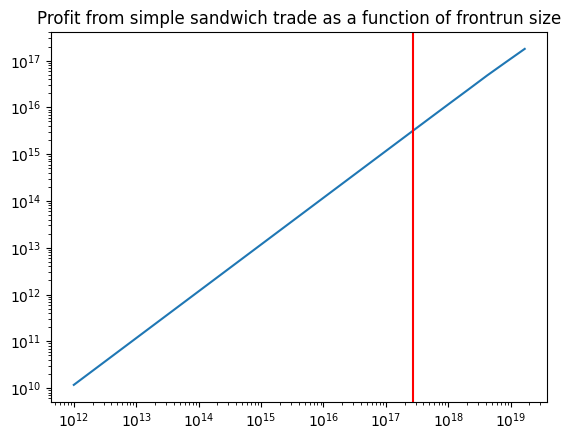

In [22]:
plt.plot(xs, ys)
plt.loglog()
plt.axvline(x=2.72994664448e+17, color='red')
plt.title('Profit from simple sandwich trade as a function of frontrun size');

In [40]:
assert pool is not None

auto_sandwich_mev(
    pool,
    swap,
    start=1e12,
    factor=10,
    pool_fee=True,
    verbose=True,
)

0: Trying 1000000.0
1: Trying 10000000.0
2: Trying 100000000.0
3: Trying 1000000000.0
4: Trying 10000000000.0
5: Trying 100000000000.0
6: Trying 1000000000000.0
7: Trying 10000000000000.0
0: Trying 1000000000000.0 - 10000000000000.0
1: Trying 5500000000000.0 - 10000000000000.0
2: Trying 5500000000000.0 - 7750000000000.0
3: Trying 5500000000000.0 - 6625000000000.0
4: Trying 6062500000000.0 - 6625000000000.0
5: Trying 6343750000000.0 - 6625000000000.0
6: Trying 6343750000000.0 - 6484375000000.0
7: Trying 6343750000000.0 - 6414062500000.0
8: Trying 6343750000000.0 - 6378906250000.0
9: Trying 6343750000000.0 - 6361328125000.0
10: Trying 6352539062500.0 - 6361328125000.0
11: Trying 6352539062500.0 - 6356933593750.0
12: Trying 6352539062500.0 - 6354736328125.0
13: Trying 6352539062500.0 - 6353637695312.0
14: Trying 6352539062500.0 - 6353088378906.0
15: Trying 6352813720703.0 - 6353088378906.0
16: Trying 6352951049804.0 - 6353088378906.0
17: Trying 6353019714355.0 - 6353088378906.0
18: Trying

AutoSandwichResult(profit=-6284193032.0, gas_fee=0.007010483569918752, frontrun_input=6353019714355.0, price_baseline=4.3577930944809406e-05, price_frontrun=4.4178991727856794e-05, price_user=4.417908996981208e-05, price_backrun=4.35782501103994e-05)

## Inspect the sandwiches created

In [7]:
engine = create_engine(postgres_uri_mp)


In [23]:

sw = pd.read_sql_query(
    """
    SELECT * FROM simple_sandwiches
    """,
    engine,
)

sw.shape

(36102, 21)

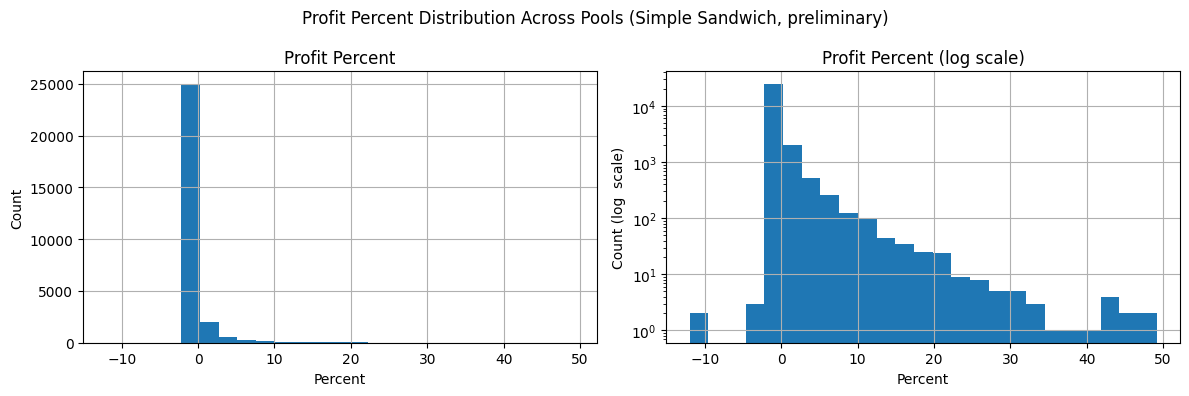

In [33]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

profits = sw.profit_percent
profits = profits[(profits < .5) & (profits > -.5)]

(profits * 100).hist(bins=25, ax=ax1)
(profits * 100).hist(bins=25, ax=ax2)

# Make log y axis
ax2.set_yscale('log')

# Set titles
ax1.set_title('Profit Percent')
ax2.set_title('Profit Percent (log scale)')

# Set x labels
ax1.set_xlabel('Percent')
ax2.set_xlabel('Percent')

# Set y labels
ax1.set_ylabel('Count')
ax2.set_ylabel('Count (log  scale)');

# Subtitle
plt.suptitle('Profit Percent Distribution Across Pools (Simple Sandwich, preliminary)');

plt.tight_layout()

In [16]:
sw = sw.assign(profit_profitable=sw.profit_percent.apply(lambda x: x if x > 0 else 0))
sw.profit_profitable.mean() * 100

0.8023819645501707

### Look at profitability relative to user swap size

,user_hash,block_number,pool,token_in,token_out,profit,profit_nofee,profit_float,profit_nofee_float,gas_fee_eth,frontrun_input,price_baseline,price_frontrun,price_user,price_backrun,profit_percent,frontrun_input_float,created_at,user_input_float,profit_per_user_input,profit_usd
0,0x05d88cc399fbdf412d66e35fce4bc9d1755be1fc440d805a77864c16a01a8838,17753030,0x25392d7129040710f152174af5019004a6f9b18d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,1778929879162456.0,1941613944222956.0,1.778930e+15,1.941614e+15,0.003519,25950565338134760,504.388435,535.332921,555.601712,522.437820,0.068551,2.595057e+16,2023-08-17 17:44:43.031393+00:00,1.700000e+16,0.104643,3.331459
1,0x10efb78bd42f69d7954fbbeec3acf959b8f7f4153a0276dafdd11b0ad4701507,17764448,0x25392d7129040710f152174af5019004a6f9b18d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0.0,0.0,0.000000e+00,0.000000e+00,0.011252,0.0,517.963473,517.963473,529.883886,529.883886,0.000000,0.000000e+00,2023-08-17 17:44:52.795973+00:00,1.000000e+16,0.000000,0.000000
2,0x49203f7ac3dafa54756f8fc2865e8a7e4fe2c3c45556e341a42e0d4cc4500891,17776161,0x25392d7129040710f152174af5019004a6f9b18d,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.0,0.0,0.000000e+00,0.000000e+00,0.004118,0.0,487.441719,487.441719,477.649065,477.649065,0.000000,0.000000e+00,2023-08-17 17:45:02.491491+00:00,3.527956e+10,0.000000,0.000000
3,0x05d53b345edade3a4a199480188d6f0bdc5b5bb2d5e8e7b8d6ac3e6dd9f09e6d,17777471,0x25392d7129040710f152174af5019004a6f9b18d,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0.0,0.0,0.000000e+00,0.000000e+00,0.007774,0.0,620.815603,620.815603,573.170499,573.170499,0.000000,0.000000e+00,2023-08-17 17:45:12.194309+00:00,1.122925e+11,0.000000,0.000000
4,0x47c4252a2e6184cf3f2c60f89246a37319e0f295cd89c6dd7f7e504cdee0238b,17780063,0x25392d7129040710f152174af5019004a6f9b18d,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x72e4f9f808c49a2a61de9c5896298920dc4eeea9,7146407185671376.0,7623944577911584.0,7.146407e+15,7.623945e+15,0.007776,77979125976562500,599.760274,692.749431,728.321738,626.503844,0.091645,7.797913e+16,2023-08-17 17:45:15.921576+00:00,2.982980e+16,0.239573,13.404745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36097,0x03b04379d5c5e05e72aba9e8815383ff6395dd38fdafe44c005abb0f71909397,17556140,0xb23ae88573926edba9c583d6c220212998bf9f67,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x51187cab377ed5e1386042919a9c3d6b5ea402f0,1349180741824848.0,2878939101328064.0,1.349181e+15,2.878939e+15,0.003118,74547271728515620,0.044401,0.045722,0.046608,0.045250,0.018098,7.454727e+16,2023-08-17 14:17:16.204931+00:00,5.000000e+16,0.026984,NaN
36098,0x1e390263360bd9ffdf972fb854a7abde3e33e0f21ed25c4827122db536139eba,17556138,0xb23ae88573926edba9c583d6c220212998bf9f67,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x51187cab377ed5e1386042919a9c3d6b5ea402f0,18373208045978.0,269980618216038.0,1.837321e+13,2.699806e+14,0.003714,12397050857543944,0.043927,0.044144,0.044624,0.044403,0.001482,1.239705e+16,2023-08-17 14:17:11.201846+00:00,2.700000e+16,0.000680,NaN
36099,0x846d18990d2922830a5301033706bac0630048ede43e1e579e24db1bbc33c130,17556124,0xb23ae88573926edba9c583d6c220212998bf9f67,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x51187cab377ed5e1386042919a9c3d6b5ea402f0,7258061180084224.0,9923534159879936.0,7.258061e+15,9.923534e+15,0.003560,126422424316406260,0.043462,0.046375,0.048217,0.045105,0.057411,1.264224e+17,2023-08-17 14:17:05.562680+00:00,8.000000e+16,0.090726,NaN
36100,0xefab8dfa7a69e69532faf244010e84b7a6a3d9332b12faea27d6ba6f2477e324,17561951,0x11b815efb8f581194ae79006d24e0d814b7697f6,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xdac17f958d2ee523a2206206994597c13d831ec7,-1189596804190044200,990094765850624.0,-1.189597e+18,9.900948e+14,0.003051,1193877499999999800000,0.000043,0.000043,0.000043,0.000043,-0.000996,1.193877e+21,2

In [25]:
engine_us = create_engine(postgres_uri_us)

pool_info = pd.read_sql_query("SELECT * FROM token_info", engine_us).set_index('pool')

pool_info.head()

,block_timestamp,block_number,transaction_hash,log_index,token0,token1,fee,tick_spacing,token0symbol,decimals0,token1symbol,decimals1
pool,,,,,,,,,,,,
0x3ffedcddd268511acc44ae67845bdd56c8417fa4,2022-05-07 04:04:57+00:00,14727619,0x608b28353bd9e08824c450b60aeec0e24fdf8921049aa0acbc79c2276d0689f9,222,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,100,1,WBTC,8.0,FUN,8.0
0xf8bc8c39a82506dc0709e626b2e882a014bb9838,2023-04-12 09:52:35+00:00,17031160,0x8c84ecaabba61d00af64fe4f272404d52cb06f60656ce0c1d467934f8fbed168,236,0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,0x66a0f676479cee1d7373f3dc2e2952778bff5bd6,100,1,HEX,8.0,WISE,18.0
0xe82c5c1ec82124ddf833800a3b61a3ec7106b18b,2021-11-13 07:18:03+00:00,13606313,0x505efb367d2a29b2ddc89f38f36a20216238cd30673bab9847f3333e22a4945a,307,0x056fd409e1d7a124bd7017459dfea2f387b6d5cd,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,GUSD,2.0,DAI,18.0
0x75bff91af9878f5ec3fede9b52d51159afc2430a,2022-05-07 04:20:49+00:00,14727691,0x2e3cc9a2dfa8d48930054952a844bef7303304250b738a445b9e1d1483c70f0b,371,0x419d0d8bdd9af5e606ae2232ed285aff190e711b,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,FUN,8.0,DAI,18.0
0xd1000344c3a00846462b4624bb452621cf2ce001,2021-11-13 07:18:03+00:00,13606313,0xf9d2dab791e3a006f2ffdade52cbf6c4a8c49a9c8cba5dbe4793014d5e2b2d76,301,0x4fabb145d64652a948d72533023f6e7a623c7c53,0x6b175474e89094c44da98b954eedeac495271d0f,100,1,BUSD,18.0,DAI,18.0


In [ ]:
pool_info = pool_info.assign(pool_name=pool_info.apply(lambda x: f"{x['token0symbol']}-{x['token1symbol']}", axis=1))

pool_info = pool_info[['pool_name']]

In [30]:
sw = pd.merge(sw, pool_info, on='pool', how='left')

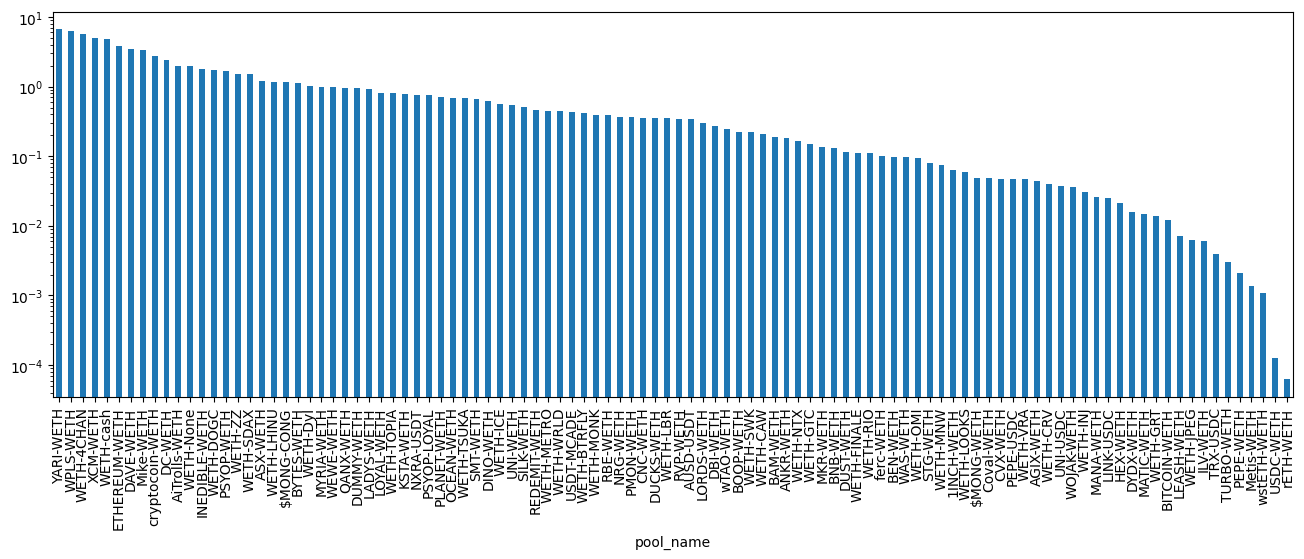

In [31]:
_, ax = plt.subplots(figsize=(16, 5))
mean_per_pool = sw.groupby('pool_name').profit_profitable.mean()
(mean_per_pool[mean_per_pool > 0] * 100).sort_values(ascending=False).plot.bar(ax=ax)

ax.set_yscale('log');

## Add profit values in USD

In [8]:
from sqlalchemy import create_engine, Column, String, Float, Integer, MetaData, Table
from sqlalchemy.orm import sessionmaker

SessionLocal = sessionmaker(bind=engine)

In [18]:
engine_us = create_engine(postgres_uri_us)

token_info = pd.read_sql_table('token_info', engine_us)

token_info0 = token_info[["token0", "decimals0"]].rename(columns={"token0": "token", "decimals0": "decimals"})
token_info1 = token_info[["token1", "decimals1"]].rename(columns={"token1": "token", "decimals1": "decimals"})

token_info = pd.concat([token_info0, token_info1], ignore_index=True).drop_duplicates().reset_index(drop=True).set_index("token")

token_info = token_info.dropna()

token_info

,decimals
token,
0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,8.0
0x2b591e99afe9f32eaa6214f7b7629768c40eeb39,8.0
0x056fd409e1d7a124bd7017459dfea2f387b6d5cd,2.0
0x419d0d8bdd9af5e606ae2232ed285aff190e711b,8.0
0x4fabb145d64652a948d72533023f6e7a623c7c53,18.0
...,...
0xe47c9edd0c2ec87c4a60b164f0564ef897e338fb,18.0
0xed21adccd7fb37d94114b211cb9ee7d602dfdb3f,2.0
0xf55b21f5bc66493d0abd269537e97f6b79da2b8a,18.0


In [21]:
session = SessionLocal()


rows = session.query(SimpleSandwich).all()
errors = 0
it = tqdm(rows)

for row in it:
    it.set_postfix(errors=errors)

    params = {
        "chain": "eth",
        "to_block": row.block_number,
        "address": row.token_in,
    }
    try:
        result = evm_api.token.get_token_price(
            api_key=moralis_api_key,
            params=params, # type: ignore
        )
    except Exception as e:
        print(e)
        errors += 1
        continue

    if result is None or "usdPrice" not in result:
        errors += 1
        continue

    try:
        decimals = token_info.loc[row.token_in, "decimals"]
    except KeyError as e:
        print(e)
        errors += 1
        continue
    

    profit_usd_value = (row.profit_float / (10**decimals)) * result["usdPrice"]
    
    # Update the table
    row.profit_usd = profit_usd_value
    session.commit()

    time.sleep(0.01)

session.close()

session.close()

  0%|          | 21/35869 [00:17<7:48:33,  1.28it/s, errors=1]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 24/35869 [00:20<7:58:45,  1.25it/s, errors=2]

(500)
Reason: Internal Server Error
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:13:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '2', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '10', 'ETag': 'W/"2-vyGp6PvFo4RvsFtPoIWeCReyIC8"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84ebc16dde8269-IAD'})
HTTP response body: b'{}'



  0%|          | 26/35869 [00:21<7:13:10,  1.38it/s, errors=3]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 27/35869 [00:22<6:15:53,  1.59it/s, errors=4]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 28/35869 [00:22<5:37:00,  1.77it/s, errors=5]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 29/35869 [00:22<5:11:33,  1.92it/s, errors=6]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 30/35869 [00:23<4:56:37,  2.01it/s, errors=7]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 31/35869 [00:23<4:42:21,  2.12it/s, errors=8]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 32/35869 [00:24<4:33:48,  2.18it/s, errors=9]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 33/35869 [00:25<5:26:41,  1.83it/s, errors=10]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 34/35869 [00:25<5:52:05,  1.70it/s, errors=11]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 39/35869 [00:30<8:02:56,  1.24it/s, errors=12]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 46/35869 [00:37<8:17:55,  1.20it/s, errors=13] 

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 47/35869 [00:37<7:13:39,  1.38it/s, errors=14]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 51/35869 [00:41<7:43:04,  1.29it/s, errors=15]

'0x3f63d380987f5d7c65b31a2a9d99bc2c446f920b'


  0%|          | 54/35869 [00:43<7:56:01,  1.25it/s, errors=16]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 56/35869 [00:44<5:14:07,  1.90it/s, errors=18]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'
'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 57/35869 [00:44<4:51:08,  2.05it/s, errors=19]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 60/35869 [00:47<6:05:28,  1.63it/s, errors=20]

(500)
Reason: Internal Server Error
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:13:53 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '2', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'x-request-weight': '10', 'ETag': 'W/"2-vyGp6PvFo4RvsFtPoIWeCReyIC8"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84ec6a1dd420ac-IAD'})
HTTP response body: b'{}'



  0%|          | 64/35869 [00:50<7:29:59,  1.33it/s, errors=21]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 65/35869 [00:51<6:31:17,  1.53it/s, errors=22]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 66/35869 [00:51<5:48:53,  1.71it/s, errors=23]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 67/35869 [00:51<5:16:25,  1.89it/s, errors=24]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 68/35869 [00:52<4:53:15,  2.03it/s, errors=25]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 69/35869 [00:52<4:38:13,  2.14it/s, errors=26]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 74/35869 [00:57<7:30:01,  1.33it/s, errors=27]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 75/35869 [00:57<6:28:36,  1.54it/s, errors=28]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 79/35869 [01:01<7:34:43,  1.31it/s, errors=29]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 80/35869 [01:01<6:33:27,  1.52it/s, errors=30]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 83/35869 [01:04<7:09:24,  1.39it/s, errors=31]

'0x2698931002b10a2206c3f8b36c8c168b01ea6c25'


  0%|          | 88/35869 [01:09<8:56:16,  1.11it/s, errors=32] 

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 89/35869 [01:09<7:31:25,  1.32it/s, errors=33]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 91/35869 [01:11<7:55:42,  1.25it/s, errors=34]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 93/35869 [01:13<8:08:35,  1.22it/s, errors=35]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 94/35869 [01:13<6:58:24,  1.43it/s, errors=36]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 96/35869 [01:15<8:28:59,  1.17it/s, errors=37]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 99/35869 [01:18<8:52:58,  1.12it/s, errors=38] 

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 100/35869 [01:19<7:54:56,  1.26it/s, errors=39]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 101/35869 [01:20<7:16:09,  1.37it/s, errors=40]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 104/35869 [01:23<8:35:52,  1.16it/s, errors=41]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 106/35869 [01:24<8:38:17,  1.15it/s, errors=42]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 109/35869 [01:27<8:53:05,  1.12it/s, errors=43] 

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 111/35869 [01:29<8:30:07,  1.17it/s, errors=44]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  0%|          | 112/35869 [01:30<7:35:12,  1.31it/s, errors=45]

'0x95e05e2abbd26943874ac000d87c3d9e115b543c'


  1%|          | 294/35869 [05:12<7:15:46,  1.36it/s, errors=47] 

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e1aa728245-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e3dda05728-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 296/35869 [05:12<4:20:13,  2.28it/s, errors=49]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e4cdc5389d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e5c8bc38fd-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 298/35869 [05:12<2:54:19,  3.40it/s, errors=51]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e6a9972082-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:18 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e788295716-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 300/35869 [05:13<2:10:56,  4.53it/s, errors=53]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e8adb681ac-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2e99dd639ac-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 302/35869 [05:13<1:51:32,  5.31it/s, errors=55]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2ea9ac5599e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2eb8b609c42-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 304/35869 [05:13<1:40:41,  5.89it/s, errors=57]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2ec7967574c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2ed7df15878-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 306/35869 [05:14<1:36:07,  6.17it/s, errors=59]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:19 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2ee5da62048-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2ef5e5720a8-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 308/35869 [05:14<1:33:09,  6.36it/s, errors=61]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f05eec9c40-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f1489f824e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 310/35869 [05:14<1:31:54,  6.45it/s, errors=63]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f239e53994-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f32aa97f72-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 312/35869 [05:15<1:31:44,  6.46it/s, errors=65]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f428921ffd-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:20 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f52db60619-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 314/35869 [05:15<1:55:10,  5.14it/s, errors=67]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:21 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f61ba40632-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:21 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f83ddc8199-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 316/35869 [05:15<1:42:21,  5.79it/s, errors=69]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:21 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2f93a670935-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:21 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fa28970607-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 318/35869 [05:16<1:37:04,  6.10it/s, errors=71]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:21 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fb2fe7394c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fc194b3897-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 320/35869 [05:16<1:32:36,  6.40it/s, errors=73]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fcfa4a3952-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fdfb7e4b87-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 322/35869 [05:16<1:33:12,  6.36it/s, errors=75]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fefcec3b62-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f2fffdfc9c5b-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 324/35869 [05:17<1:33:11,  6.36it/s, errors=77]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:22 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f300ec4b82ba-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f301dc0b9c46-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 326/35869 [05:17<1:35:25,  6.21it/s, errors=79]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f302ddf605bf-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f303ff53081d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 328/35869 [05:17<1:35:05,  6.23it/s, errors=81]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f304df460a15-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f305dec30a11-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 330/35869 [05:18<1:32:41,  6.39it/s, errors=83]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f306da0b8275-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:23 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f307dd983898-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 332/35869 [05:18<1:30:15,  6.56it/s, errors=85]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:24 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f308ccfe3ae8-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:24 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f309bdd2064d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 333/35869 [05:18<1:33:37,  6.33it/s, errors=86]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:24 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f30abda73b3e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 335/35869 [05:19<1:55:36,  5.12it/s, errors=88]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:24 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f30bbafe081c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:24 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f30ddb205b76-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 337/35869 [05:19<1:40:43,  5.88it/s, errors=90]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f30eb833173f-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f30fabf420b2-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 339/35869 [05:19<1:35:30,  6.20it/s, errors=92]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f310a9aa82a5-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3119e22579a-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 341/35869 [05:19<1:34:29,  6.27it/s, errors=94]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31298e00594-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:25 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f313987a3ae1-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 343/35869 [05:20<1:32:40,  6.39it/s, errors=96]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3149b18381d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3158aa4172d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 345/35869 [05:20<1:29:38,  6.61it/s, errors=98]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3167f191fe5-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3175d46204b-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 347/35869 [05:20<1:31:07,  6.50it/s, errors=100]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3184d3781fd-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31949b05914-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 349/35869 [05:21<1:30:40,  6.53it/s, errors=102]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:26 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31a5c3a3956-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:27 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31b39af20c4-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 351/35869 [05:21<1:30:28,  6.54it/s, errors=104]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:27 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31c2bd38200-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:27 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31d2f5f3b18-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 353/35869 [05:21<1:31:16,  6.48it/s, errors=106]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:27 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31e08881366-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:27 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f31f0c688000-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 355/35869 [05:22<1:54:49,  5.15it/s, errors=108]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3200fce39b5-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3222b184b8a-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 357/35869 [05:22<1:41:05,  5.85it/s, errors=110]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3232b9307a4-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3240de4082e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 359/35869 [05:22<1:41:22,  5.84it/s, errors=112]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32508932024-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3260fe220c0-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 361/35869 [05:23<1:37:18,  6.08it/s, errors=114]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:28 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3272c5b1745-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3281f972d07-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 363/35869 [05:23<1:33:50,  6.31it/s, errors=116]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3292ecf0814-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32a0d300649-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 365/35869 [05:23<1:33:09,  6.35it/s, errors=118]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32b18692057-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32c0a41081e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 367/35869 [05:24<1:32:48,  6.38it/s, errors=120]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:29 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32cf91e05e8-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32e09f67faa-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 369/35869 [05:24<1:31:27,  6.47it/s, errors=122]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32eff0039a0-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f32fe88a38dd-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 371/35869 [05:24<1:31:12,  6.49it/s, errors=124]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f330e8171fd3-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f331dd7e5848-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 373/35869 [05:25<1:30:59,  6.50it/s, errors=126]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:30 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f332c9158272-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:31 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f333bbb73975-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 375/35869 [05:25<1:58:36,  4.99it/s, errors=128]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:31 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f334be5c572e-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:31 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3370992201c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 377/35869 [05:25<1:44:41,  5.65it/s, errors=130]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:31 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f337fb632d15-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:31 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f338fab05b34-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 379/35869 [05:26<1:36:40,  6.12it/s, errors=132]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f339ec93387f-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33ad95107a8-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 381/35869 [05:26<1:34:23,  6.27it/s, errors=134]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33bc8795a94-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33cba129c8a-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 383/35869 [05:26<1:33:43,  6.31it/s, errors=136]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33dbfcf82f9-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33ebd0e1727-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 385/35869 [05:27<1:30:46,  6.52it/s, errors=138]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:32 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f33fbb46081f-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f340981b82f6-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 387/35869 [05:27<1:31:56,  6.43it/s, errors=140]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3418a28084b-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3428ca83949-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 389/35869 [05:27<1:32:06,  6.42it/s, errors=142]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3438c0982fc-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f344899a8232-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 391/35869 [05:28<1:30:19,  6.55it/s, errors=144]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34579d957be-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:33 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3465f6239af-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 393/35869 [05:28<1:29:13,  6.63it/s, errors=146]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3475e470aa9-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3484b9620ab-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 395/35869 [05:28<1:54:57,  5.14it/s, errors=148]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34948cd5b47-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34b686c398c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 397/35869 [05:29<1:46:04,  5.57it/s, errors=150]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:34 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34c8deb0a8b-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34d8892175a-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 399/35869 [05:29<1:39:29,  5.94it/s, errors=152]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34e799a58cc-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f34f8f510606-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 401/35869 [05:29<1:37:09,  6.08it/s, errors=154]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3506a613894-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f351895739b8-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 403/35869 [05:30<1:32:55,  6.36it/s, errors=156]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:35 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3527c1b802a-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f35368b33b44-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 405/35869 [05:30<1:33:05,  6.35it/s, errors=158]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f35458de05ab-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3555a3c094d-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 407/35869 [05:30<1:29:43,  6.59it/s, errors=160]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3564ffc8226-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f357385f39a6-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 409/35869 [05:31<1:32:21,  6.40it/s, errors=162]

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:36 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f358393f2d22-IAD'})
HTTP response body: b'{"message":"Invalid key"}'

(401)
Reason: Unauthorized
HTTP response headers: HTTPHeaderDict({'Date': 'Thu, 17 Aug 2023 21:18:37 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Content-Length': '25', 'Connection': 'keep-alive', 'X-Powered-By': 'Express', 'Access-Control-Allow-Origin': '*', 'ETag': 'W/"19-aa5ews+8iO9r0nbrJ9a59/u0j00"', 'Vary': 'Accept-Encoding', 'CF-Cache-Status': 'DYNAMIC', 'Server': 'cloudflare', 'CF-RAY': '7f84f3592a133b3c-IAD'})
HTTP response body: b'{"message":"Invalid key"}'



  1%|          | 409/35869 [05:31<7:58:36,  1.23it/s, errors=162]


KeyboardInterrupt: 

## Spurious calculations

In [ ]:
# Given 17 seconds per sandwich, how many sandwiches can you make in a night?
hours_per_night = 8
seconds_per_sandwich = 17
cpus = 1

hours_per_night * 60 * 60 / seconds_per_sandwich * cpus

1694.1176470588234